In [11]:
import polars as pl

df = pl.read_csv(
    "../data/primary.tsv",
    separator="\t",
    has_header=True,
    skip_rows=2,
    infer_schema_length=1000,
    null_values=["", "NA", "NaN"]
)


In [12]:
print(df.shape)
df.head()

(26321, 7)


num,name,element,str3,utc,tc,journal
i64,str,str,str,str,f64,str
2,"""(Ba,La)2CuO4""","""Ba0.2La1.8Cu1O4-Y""","""T""","""K""",29.0,"""Jpn.J.Appl.Phys., 26(1987)L223"""
3,"""(Ba,La,Ag)2CuO4""","""Ba0.1La1.9Ag0.1Cu0.9O4-Y""","""T""","""K""",26.0,"""Jpn.J.Appl.Phys., 26(1987)L223"""
4,"""(Ba,La,)2CuO4""","""Ba0.1La1.9Cu1O4-Y""","""T""","""K""",19.0,"""Jpn.J.Appl.Phys., 26(1987)L223"""
5,"""(Ba,La)2CuO4""","""Ba0.15La1.85Cu1O4-Y""","""T""","""K""",22.0,"""Jpn.J.Appl.Phys., 26(1987)L223"""
6,"""(Ba,La)2CuO4""","""Ba0.3La1.7Cu1O4-Y""","""T""","""K""",23.0,"""Jpn.J.Appl.Phys., 26(1987)L223"""


In [13]:
df = df.rename({
    "num": "data_number",
    "name": "common_formula",
    "element": "chemical_formula",
    "str3": "structure_name",
    "utc": "tc_unit",
    "tc": "tc_recommended",
    "journal": "journal",
})


In [14]:
df = df.with_columns(
    pl.col("tc_recommended")
      .cast(pl.Utf8, strict=False)
      .str.strip_chars()
      .str.replace_all(r"[^\d\.\-eE]", "")
      .cast(pl.Float64, strict=False)
)

In [15]:
df.write_parquet("supercon_primary.parquet")

In [16]:
PARQUET = "supercon_primary.parquet"

expected_cols = {
    "data_number": pl.Utf8,
    "common_formula": pl.Utf8,
    "chemical_formula": pl.Utf8,
    "structure_name": pl.Utf8,
    "tc_unit": pl.Utf8,
    "tc_recommended": pl.Float64,  # asumimos que ya lo convertiste a float
    "journal": pl.Utf8,
}
missing = [c for c in expected_cols if c not in df.columns]
extra = [c for c in df.columns if c not in expected_cols]
if missing:
    raise ValueError(f"Faltan columnas: {missing}")

df = df.with_columns([
    pl.col(c).cast(t, strict=False) for c, t in expected_cols.items()
])

df = df.with_columns(pl.col("tc_unit").str.strip_chars().str.to_uppercase())

allowed_units = {"K"}
units_found = set(df.select(pl.col("tc_unit").drop_nans().drop_nulls().unique()).to_series().to_list())
unknown_units = units_found - allowed_units
if unknown_units:
    print(f"AVISO: Unidades inesperadas en tc_unit: {sorted(unknown_units)} (revisa)")

stats = df.select([
    pl.len().alias("n_rows"),
    pl.col("tc_recommended").null_count().alias("tc_nulls"),
    pl.col("tc_recommended").min().alias("tc_min"),
    pl.col("tc_recommended").max().alias("tc_max"),
    pl.col("tc_recommended").quantile(0.50).alias("tc_p50"),
    pl.col("tc_recommended").quantile(0.95).alias("tc_p95"),
])
print("Resumen Tc:\n", stats)

neg_tc = df.filter(pl.col("tc_recommended") < 0).height
if neg_tc > 0:
    print(f"AVISO: {neg_tc} filas tienen Tc negativa. Revisa el parsing o el origen.")

THRESH = 300.0  # Kelvin; ajusta si esperas hidruros de alta presión > 300K
high_tc = df.filter(pl.col("tc_recommended") > THRESH).height
if high_tc > 0:
    print(f"AVISO: {high_tc} filas con Tc > {THRESH} K. Revisa si son válidas o requieren bandera.")


for col in ["chemical_formula", "journal"]:
    empties = df.filter(pl.col(col).is_null() | (pl.col(col).str.strip_chars() == "")).height
    if empties > 0:
        print(f"AVISO: {empties} filas con {col} vacío.")



Resumen Tc:
 shape: (1, 6)
┌────────┬──────────┬────────┬────────┬────────┬────────┐
│ n_rows ┆ tc_nulls ┆ tc_min ┆ tc_max ┆ tc_p50 ┆ tc_p95 │
│ ---    ┆ ---      ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ u32    ┆ u32      ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞════════╪══════════╪════════╪════════╪════════╪════════╡
│ 26321  ┆ 0        ┆ 0.0    ┆ 323.0  ┆ 17.1   ┆ 93.4   │
└────────┴──────────┴────────┴────────┴────────┴────────┘
AVISO: 1 filas con Tc > 300.0 K. Revisa si son válidas o requieren bandera.


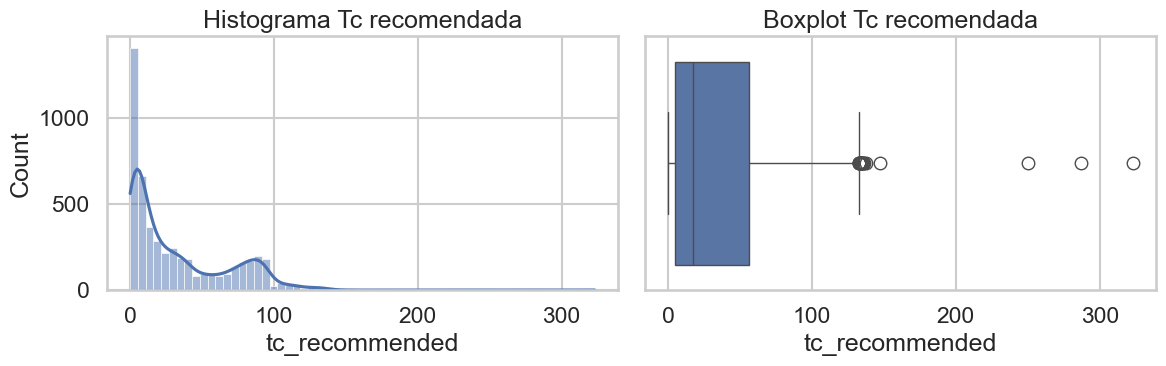

In [17]:
import seaborn as sns

import matplotlib.pyplot as plt

plot_df = df.sample(5000, seed=0) if df.height > 5000 else df
pd_df = plot_df.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=pd_df, x="tc_recommended", bins=60, kde=True, ax=axes[0])
axes[0].set_title("Histograma Tc recomendada")

sns.boxplot(data=pd_df, x="tc_recommended", ax=axes[1])
axes[1].set_title("Boxplot Tc recomendada")

plt.tight_layout()
plt.show()

# Perfilación de duplicados

In [18]:
key_cols = ["chemical_formula", "journal"]
dup_groups = (
    df.group_by(key_cols)
      .agg(pl.len().alias("n"))
      .filter(pl.col("n") > 1)
      .sort("n", descending=True)
)

print(f"Grupos duplicados por {key_cols}: {dup_groups.height}")
print("Top 10 grupos duplicados:")
print(dup_groups.head(10))


Grupos duplicados por ['chemical_formula', 'journal']: 1575
Top 10 grupos duplicados:
shape: (10, 3)
┌───────────────────────────┬─────────────────────────────────┬─────┐
│ chemical_formula          ┆ journal                         ┆ n   │
│ ---                       ┆ ---                             ┆ --- │
│ str                       ┆ str                             ┆ u32 │
╞═══════════════════════════╪═════════════════════════════════╪═════╡
│ M1Ta1S2                   ┆ Science, 174(1971)493           ┆ 36  │
│ Hg1Ba2Cu1O4+z             ┆ Phys.Rev.B, 63(2001)024504      ┆ 12  │
│ M1Ta1S2                   ┆ Mat.Res.Bull. , 14(1979)797     ┆ 11  │
│ M1Ti1N1Cl1                ┆ J.Mater.Chem., 22(2012)10752    ┆ 11  │
│ Bi2Sr1.6La0.4Cu1Oz        ┆ Phys.Rev.B,62(2000)11989-11992  ┆ 10  │
│ Tl2Ba2Cu1O6+Z             ┆ J.PHYS.SOC.JAPAN,59(1990)3839   ┆ 8   │
│ Bi1.8Pb0.2Sr2Ca1Cu2O8-Z   ┆ J.Superconductivity , 11(1998)… ┆ 8   │
│ M1Ta1S2                   ┆ Mat.Res.Bull. , 9(1974)1597  

In [19]:
dups_detail = (
    df.join(dup_groups.select(key_cols), on=key_cols, how="inner")
      .sort(key_cols + ["tc_recommended"], descending=[False, False, True])
      .head(200)
)
dups_detail.write_csv("duplicates_sample.tsv", separator="\t")
print("Muestra de duplicados guardada en duplicates_sample.tsv")

Muestra de duplicados guardada en duplicates_sample.tsv


# Deduplicación

In [20]:
df_dedup = (
    df.sort(["chemical_formula", "journal", "tc_recommended"], descending=[False, False, True])
      .unique(subset=key_cols, keep="first")  # conserva el primer registro de cada grupo (mayor Tc)
)

print("Shape original:", df.shape, "| Shape dedup:", df_dedup.shape)
df_dedup.write_parquet("supercon_primary_dedup.parquet")
print("Deduplicado guardado en supercon_primary_dedup.parquet")

Shape original: (26321, 7) | Shape dedup: (24155, 7)
Deduplicado guardado en supercon_primary_dedup.parquet


# Reporte de Calidad

In [21]:
def f(x):
    # Convierte a float preservando None -> null
    return float(x) if x is not None else None

metrics = [
    "rows", "tc_nulls", "tc_min", "tc_p50", "tc_p95", "tc_max",
    "high_tc(>300K)", "neg_tc", "dup_groups(key)"
]

# Extrae los valores desde 'stats' y los fuerza a float para no mezclar int/float
vals_stats = [
    f(stats["n_rows"][0]),
    f(stats["tc_nulls"][0]),
    f(stats["tc_min"][0]),
    f(stats["tc_p50"][0]),
    f(stats["tc_p95"][0]),
    f(stats["tc_max"][0]),
]

values = vals_stats + [f(high_tc), f(neg_tc), f(dup_groups.height)]

# Fuerza esquema: 'value' = Float64
quality_report = pl.DataFrame(
    {"metric": metrics, "value": values},
    schema={"metric": pl.Utf8, "value": pl.Float64},
)

quality_report.write_csv("quality_report.tsv", separator="\t")
print("Reporte de calidad escrito en quality_report.tsv")

Reporte de calidad escrito en quality_report.tsv


In [22]:
# inspect_outliers_and_flag.py
import polars as pl

PARQUET = "supercon_primary.parquet"  # generado antes
HIGH_TC = 300.0                       # umbral de outlier (ajústalo si hace falta)

df = pl.read_parquet(PARQUET)

# --- 1) Ver los Tc más altos (top 20) ---
top_tc = (
    df.sort("tc_recommended", descending=True)
      .select(["data_number","chemical_formula","common_formula","structure_name","tc_unit","tc_recommended","journal"])
      .head(20)
)
print("Top Tc:")
print(top_tc)

# --- 2) Identificar el/los outliers (> HIGH_TC) y validar unidad ---
sus = df.filter(pl.col("tc_recommended") > HIGH_TC)

print(f"\nFilas con Tc > {HIGH_TC} K: {sus.height}")
print(sus.select(["data_number","chemical_formula","tc_recommended","tc_unit","journal"]))

print("\nUnidades entre los outliers:")
print(sus.group_by("tc_unit").len())

# Contexto: ver todo el grupo por (chemical_formula, journal) donde aparece el outlier
key_cols = ["chemical_formula","journal"]
dup_context = (
    df.join(sus.select(key_cols).unique(), on=key_cols, how="inner")
      .sort(key_cols + ["tc_recommended"], descending=[False, False, True])
)
print("\nContexto del/los grupos con outliers (muestra 50):")
print(dup_context.head(50))

# Guardar una muestra para revisar en editor
dup_context.head(200).write_csv("outlier_context.tsv", separator="\t")

# --- 3) Marcar filas sospechosas con una política clara ---
quality_flag = (
    pl.when(pl.col("tc_recommended").is_null()).then(pl.lit("tc_missing"))
     .when(pl.col("tc_recommended") < 0).then(pl.lit("tc_negative"))
     .when(pl.col("tc_unit").str.strip_chars().str.to_uppercase() != "K").then(pl.lit("unit_not_K"))
     .when(pl.col("tc_recommended") > HIGH_TC).then(pl.lit("tc_gt_300"))
     .when(pl.col("tc_recommended") > 150).then(pl.lit("tc_gt_150"))  # “alto pero plausible”
     .otherwise(pl.lit("ok"))
)

df = df.with_columns(quality_flag.alias("quality_flag"))

# Exporta las filas no “ok” para inspección
df.filter(pl.col("quality_flag") != "ok").write_csv("suspect_rows.tsv", separator="\t")

# --- 4) Dataset depurado para modelado/EDA conservador ---
df_ok = df.filter(pl.col("quality_flag") == "ok")
df_ok.write_parquet("supercon_primary_ok.parquet")
print("\nShapes | original:", df.shape, "| ok:", df_ok.shape)

# --- 5) Estadísticas recortadas (sin outliers) ---
trim = df.filter(
    (pl.col("tc_recommended").is_not_null()) &
    (pl.col("tc_recommended") >= 0) &
    (pl.col("tc_recommended") <= HIGH_TC)
)
trim_stats = trim.select([
    pl.len().alias("n_rows"),
    pl.col("tc_recommended").min().alias("tc_min"),
    pl.col("tc_recommended").quantile(0.50).alias("tc_p50"),
    pl.col("tc_recommended").quantile(0.95).alias("tc_p95"),
    pl.col("tc_recommended").max().alias("tc_max"),
])
print("\nResumen Tc (recortado):")
print(trim_stats)

Top Tc:
shape: (20, 7)
┌─────────────┬──────────────┬──────────────┬──────────────┬─────────┬──────────────┬──────────────┐
│ data_number ┆ chemical_for ┆ common_formu ┆ structure_na ┆ tc_unit ┆ tc_recommend ┆ journal      │
│ ---         ┆ mula         ┆ la           ┆ me           ┆ ---     ┆ ed           ┆ ---          │
│ i64         ┆ ---          ┆ ---          ┆ ---          ┆ str     ┆ ---          ┆ str          │
│             ┆ str          ┆ str          ┆ str          ┆         ┆ f64          ┆              │
╞═════════════╪══════════════╪══════════════╪══════════════╪═════════╪══════════════╪══════════════╡
│ 9632        ┆ Pb2C1Ag2O6   ┆ PbCO3.2PbO+A ┆ null         ┆ K       ┆ 323.0        ┆ Physica C,   │
│             ┆              ┆ g2O          ┆              ┆         ┆              ┆ 351(2001)78- │
│             ┆              ┆              ┆              ┆         ┆              ┆ 81           │
│ 158986      ┆ C1S1         ┆ C-S-H        ┆ null         ┆ K      

In [23]:
top_tc["journal"].unique()
journals : list = top_tc["journal"].to_list()

In [24]:
print(journals)

['Physica C, 351(2001)78-81', 'Nature, 586(2020)373', 'Phys.Rev.B, 98(2018)014518', 'Phys.Rev.B, 98(2018)014518', 'J.PHYS.C,20(1987)673', 'Nature 569(2019)528', 'Nature, 525(2015)73', 'cond-mat/1412.0460', 'Physica C, 552(2018)27', 'Physica C, 552(2018)27', 'Physica C.,246(1995)207-215', 'J.Phys.;Cond.Matter9(1997)1451-1460', 'Solid State Commun., 149(2009)281', 'SOLID STATE COMMUN.,75(1990)617', 'SOLID STATE COMMUN.,75(1990)617', 'Physica.C,298(1998)49-58', 'Phys.Rev.B,51(1995)3261', 'Phys.Rev.B,54(1996)4265', 'Physica.C,298(1998)49-58', 'Physica C,221(1994)1-10']


## Distribución de Tc por grupos
Exploramos cómo cambia la distribución de `tc_recommended` entre banderas de calidad, décadas de publicación y familias químicas relevantes. Esto ayuda a validar que los resultados depurados mantengan patrones coherentes y a detectar anomalías residuales.

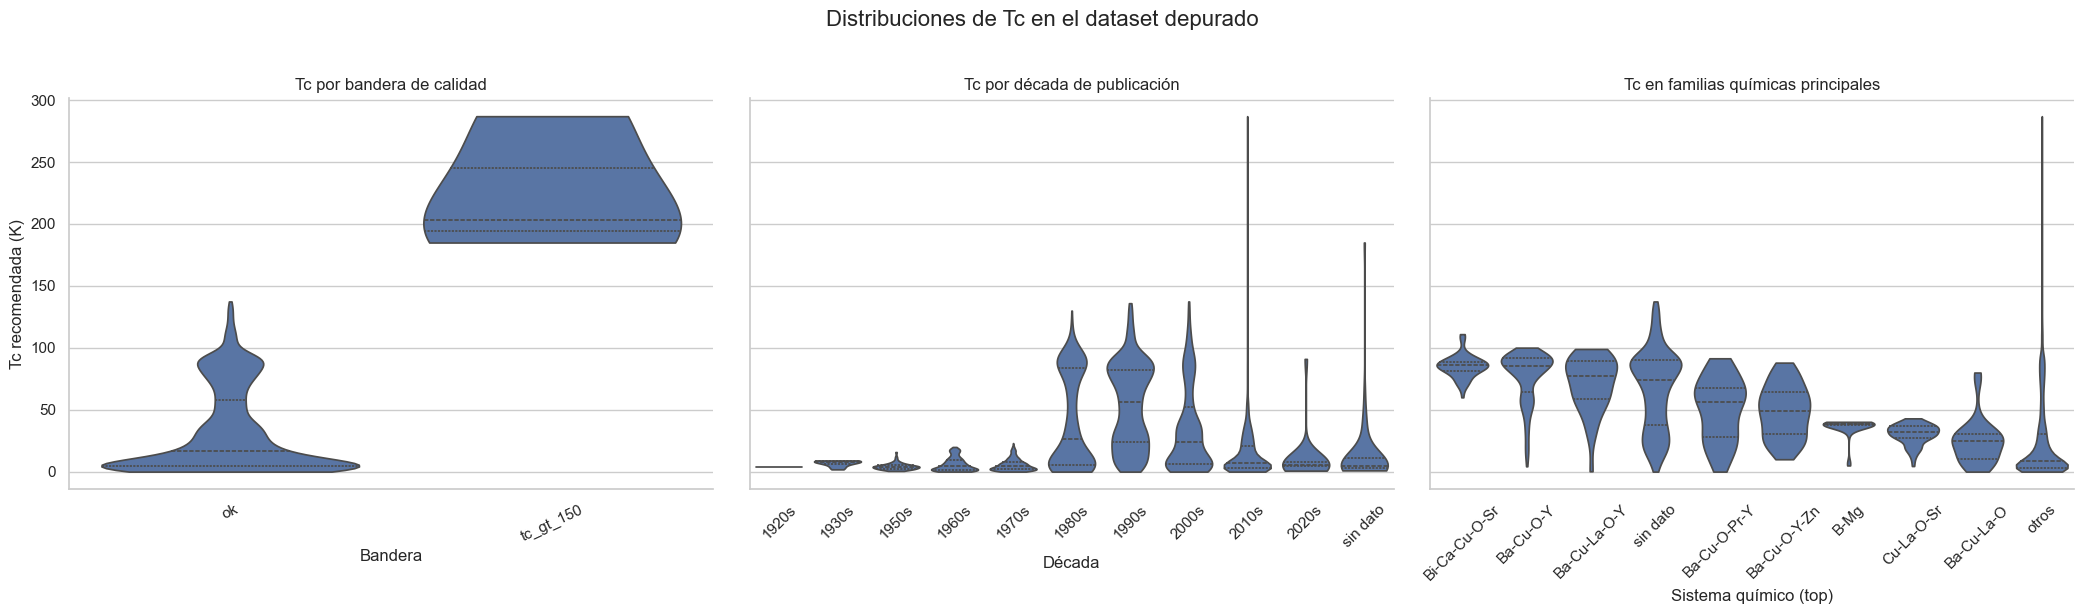

In [25]:
import re
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pymatgen.core import Composition

# Usa el DataFrame depurado si está en memoria; si no, levanta desde parquet
if "df" not in globals():
    df = pl.read_parquet("supercon_primary.parquet")

HIGH_TC = 300.0

if "quality_flag" not in df.columns:
    quality_flag = (
        pl.when(pl.col("tc_recommended").is_null()).then(pl.lit("tc_missing"))
         .when(pl.col("tc_recommended") < 0).then(pl.lit("tc_negative"))
         .when(pl.col("tc_unit").str.strip_chars().str.to_uppercase() != "K").then(pl.lit("unit_not_K"))
         .when(pl.col("tc_recommended") > HIGH_TC).then(pl.lit("tc_gt_300"))
         .when(pl.col("tc_recommended") > 150).then(pl.lit("tc_gt_150"))
         .otherwise(pl.lit("ok"))
    )
    df = df.with_columns(quality_flag.alias("quality_flag"))

YEAR_PAREN = re.compile(r"\((\d{4})\)")
YEAR_ANY = re.compile(r"\b(19|20)\d{2}\b")


def extract_year(text: str | None) -> int | None:
    if text is None:
        return None
    match = YEAR_PAREN.search(text)
    if match:
        year = int(match.group(1))
        return year if 1900 <= year <= 2100 else None
    match = YEAR_ANY.search(text)
    if match:
        year = int(match.group(0))
        return year if 1900 <= year <= 2100 else None
    return None


def chemsys_only(formula: str | None) -> str | None:
    if formula is None:
        return None
    try:
        return Composition(formula).chemical_system
    except Exception:
        return None


def format_decade(decade_value: float | int | None) -> str:
    if pd.isna(decade_value):
        return "sin dato"
    return f"{int(decade_value)}s"


SAMPLE_SIZE = 8000
sns.set_theme(style="whitegrid")

# Enriquecemos con año, década y familia química
with_meta = df.with_columns([
    pl.col("journal").map_elements(extract_year, return_dtype=pl.Int32).alias("pub_year"),
    pl.coalesce([pl.col("chemical_formula"), pl.col("common_formula")]).alias("formula_for_family"),
])
with_meta = with_meta.with_columns([
    ((pl.col("pub_year") // 10) * 10).cast(pl.Int32).alias("pub_decade"),
    pl.col("formula_for_family").map_elements(chemsys_only, return_dtype=pl.Utf8).alias("chemsys"),
])
with_meta = with_meta.drop("formula_for_family")

base = with_meta.drop_nulls(subset=["tc_recommended"])
if base.height == 0:
    raise ValueError("No hay datos con Tc para graficar")

sample = base.sample(n=SAMPLE_SIZE, seed=42) if base.height > SAMPLE_SIZE else base
plot_pd = sample.to_pandas()

plot_pd["quality_flag"] = plot_pd["quality_flag"].fillna("desconocido")
plot_pd["pub_decade_label"] = plot_pd["pub_decade"].apply(format_decade)
plot_pd["chemsys"] = plot_pd["chemsys"].fillna("sin dato")

# Top familias químicas para evitar saturar el gráfico
TOP_FAMILIES = 9
chemsys_counts = plot_pd["chemsys"].value_counts()
top_chemsys = chemsys_counts.head(TOP_FAMILIES).index.tolist()
plot_pd["chemsys_top"] = plot_pd["chemsys"].where(plot_pd["chemsys"].isin(top_chemsys), "otros")

# Órdenes de ejes
preferred_quality_order = ["ok", "tc_gt_150", "tc_gt_300", "unit_not_K", "tc_negative", "tc_missing", "desconocido"]
quality_order = [c for c in preferred_quality_order if c in plot_pd["quality_flag"].unique()]
quality_order += [c for c in plot_pd["quality_flag"].unique() if c not in quality_order]

decade_numeric = sorted(plot_pd.loc[plot_pd["pub_decade"].notna(), "pub_decade"].unique())
decade_order = [format_decade(d) for d in decade_numeric]
if "sin dato" in plot_pd["pub_decade_label"].values:
    decade_order.append("sin dato")

chemsys_order = (
    plot_pd.groupby("chemsys_top")["tc_recommended"].median().sort_values(ascending=False).index.tolist()
)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

sns.violinplot(
    data=plot_pd,
    x="quality_flag",
    y="tc_recommended",
    order=quality_order,
    inner="quartile",
    density_norm="width",
    cut=0,
    ax=axes[0],
)
axes[0].set_title("Tc por bandera de calidad")
axes[0].set_xlabel("Bandera")
axes[0].set_ylabel("Tc recomendada (K)")
axes[0].tick_params(axis="x", rotation=25)

sns.violinplot(
    data=plot_pd,
    x="pub_decade_label",
    y="tc_recommended",
    order=decade_order,
    inner="quartile",
    density_norm="width",
    cut=0,
    ax=axes[1],
)
axes[1].set_title("Tc por década de publicación")
axes[1].set_xlabel("Década")
axes[1].set_ylabel("")
axes[1].tick_params(axis="x", rotation=45)

sns.violinplot(
    data=plot_pd,
    x="chemsys_top",
    y="tc_recommended",
    order=chemsys_order,
    inner="quartile",
    density_norm="width",
    cut=0,
    ax=axes[2],
)
axes[2].set_title("Tc en familias químicas principales")
axes[2].set_xlabel("Sistema químico (top)")
axes[2].set_ylabel("")
axes[2].tick_params(axis="x", rotation=45)

fig.suptitle("Distribuciones de Tc en el dataset depurado", fontsize=16, y=1.02)
plt.tight_layout()
sns.despine()
plt.show()


# EDA y Entrenamiento

In [26]:
# ================== ETL + FEATURES PARA: num,name,element,str3,utc,tc,journal ==================
import re, hashlib, numpy as np, polars as pl
from pymatgen.core import Composition
from mendeleev import element as m_el
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import math

# --- 0) Cargar con tus columnas exactas ---
df = pl.read_csv("../data/primary.tsv", separator="\t", skip_rows=2, has_header=True)
assert set(["num","name","element","str3","utc","tc","journal"]).issubset(df.columns), df.columns

# --- 1) Normalización de fórmula y Tc ---
_ZVAR = re.compile(r'([A-Z][a-z]?\d*(?:\.\d+)?)\s*[\+\-](?:z|Z|δ|x|y)')  # O4+z -> O4
def clean_formula(s: str) -> str:
    if s is None: return None
    x = s.strip().replace(" ", "")
    x = re.sub(r'-[A-Za-z0-9]+$', '', x)   # quita sufijos finales tipo -Y
    x = _ZVAR.sub(r'\1', x)                # limpia variables estequiométricas
    return x

df_tc = (
    df.with_columns([
        # prefiero 'element' si viene poblada; si no, 'name'
        pl.when(pl.col("element").is_not_null() & (pl.col("element").str.len_chars() > 0))
          .then(pl.col("element"))
          .otherwise(pl.col("name"))
          .map_elements(clean_formula, return_dtype=pl.Utf8)
          .alias("formula"),
        pl.col("tc").cast(pl.Float64, strict=False).alias("Tc_K"),
        pl.col("utc").cast(pl.Utf8)
    ])
    .filter(pl.col("formula").is_not_null() & pl.col("Tc_K").is_not_null())
)

# Valida unidad (K); si no fuese K, aquí convertirías
if df_tc.select(pl.col("utc").n_unique()).item() != 1 or df_tc.select(pl.first("utc")).item() != "K":
    print("AVISO: 'utc' no es todo 'K'. Ajusta conversión si aplica.")

# Marca outliers de la tabla top_tc (opcional)
df_tc = df_tc.with_columns((pl.col("Tc_K") > 200.0).alias("flag_top_tc"))

# --- 2) material_id + Bag-of-Elements (BoE) ---
ELEMENTS = [
    "H","He","Li","Be","B","C","N","O","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar",
    "K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr",
    "Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe",
    "Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf",
    "Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn"
]
def reduced_formula_only(f: str) -> str:
    try: return Composition(f).reduced_formula
    except: return None
def chemsys_only(f: str) -> str:
    try: return Composition(f).chemical_system
    except: return None
def boe_vector(f: str) -> list[float]:
    try:
        comp = Composition(f)
        d = comp.get_el_amt_dict(); tot = sum(d.values())
        fr = {el: float(v)/tot for el,v in d.items()}
    except: fr = {}
    return [fr.get(el, 0.0) for el in ELEMENTS]

df_tc = df_tc.with_columns([
    pl.col("formula").map_elements(reduced_formula_only, return_dtype=pl.Utf8).alias("formula_reduced"),
    pl.col("formula").map_elements(chemsys_only,        return_dtype=pl.Utf8).alias("chemsys"),
    pl.col("formula").map_elements(boe_vector,          return_dtype=pl.List(pl.Float64)).alias("boe_vec"),
])

# Expandir List -> columnas (usar .list.get, NO .arr.get)
for i, el in enumerate(ELEMENTS):
    df_tc = df_tc.with_columns(
        pl.col("boe_vec").list.get(i).cast(pl.Float64).fill_null(0.0).alias(f"frac_{el}")
    )
df_tc = df_tc.drop("boe_vec")

df_tc = df_tc.with_columns(
    (-pl.sum_horizontal([pl.col(f"frac_{el}") * (pl.col(f"frac_{el}") + 1e-12).log() for el in ELEMENTS]))
    .alias("comp_entropy")
)

def make_material_id(r: str, c: str) -> str:
    return hashlib.md5(f"{r or ''}|{c or ''}".encode()).hexdigest()[:12]
df_tc = df_tc.with_columns(
    pl.struct(["formula_reduced","chemsys"]).map_elements(
        lambda s: make_material_id(s["formula_reduced"], s["chemsys"]),
        return_dtype=pl.Utf8
    ).alias("material_id")
)

# --- 3) Magpie-like compactos ---
def build_elem_table(elem_list=ELEMENTS):
    rows=[]
    for sym in elem_list:
        e = m_el(sym)
        rows.append({
            "symbol": sym,
            "atomic_mass": float(e.atomic_weight) if e.atomic_weight else None,
            "en_pauling": float(e.en_pauling) if e.en_pauling else None,
            "atomic_radius": float(e.atomic_radius) if e.atomic_radius else None,
            "density": float(e.density) if e.density else None,
            "electron_affinity": float(e.electron_affinity) if e.electron_affinity else None,
            "ionization_energy": float(e.ionenergies.get(1)) if getattr(e,"ionenergies",None) else None,
            "fusion_heat": float(e.heat_of_fusion) if getattr(e,"heat_of_fusion",None) else None,
            "thermal_conductivity": float(e.thermal_conductivity) if e.thermal_conductivity else None,
            "group": e.group_id if e.group_id else None,
            "period": e.period if e.period else None,
        })
    return pl.DataFrame(rows)

elem_tbl = build_elem_table()
PROP_KEYS = ["en_pauling","atomic_mass","atomic_radius","electron_affinity",
             "ionization_energy","density","thermal_conductivity","fusion_heat","group","period"]
prop_maps = {k: {r["symbol"]: (r[k] if r[k] is not None else float("nan"))
                 for r in elem_tbl.iter_rows(named=True)} for k in PROP_KEYS}

frac_cols = [f"frac_{el}" for el in ELEMENTS]

# ---- FIX: devolver dict (Struct) en lugar de tuple (List) ----
RET_STRUCT = pl.Struct([
    pl.Field("wmean", pl.Float64),
    pl.Field("mean", pl.Float64),
    pl.Field("wstd", pl.Float64),
    pl.Field("range", pl.Float64),
    pl.Field("wentropy", pl.Float64),
])

def magpie_stats_from_row(row_dict: dict, prop_map: dict) -> dict:
    items = []
    for el in ELEMENTS:
        f = row_dict.get(f"frac_{el}", 0.0) or 0.0
        if f > 0:
            Pi = prop_map.get(el, np.nan)
            if Pi is not None and not np.isnan(Pi):
                items.append((f, float(Pi)))

    if not items:
        return {"wmean": np.nan, "mean": np.nan, "wstd": np.nan, "range": np.nan, "wentropy": np.nan}

    f_arr = np.array([x[0] for x in items], float)
    p_arr = np.array([x[1] for x in items], float)

    # estadísticas básicas
    wmean = float(np.dot(f_arr, p_arr))
    mean  = float(np.mean(p_arr))
    wstd  = float(np.sqrt(np.dot(f_arr, (p_arr - wmean) ** 2)))
    prng  = float(np.max(p_arr) - np.min(p_arr))

    # --- entropía robusta (evita log de <= 0) ---
    # 1) desplaza a dominio positivo
    p_min = float(np.min(p_arr))
    p_pos = p_arr - p_min + 1e-9  # >= 1e-9
    # 2) pesos proporcionales a fracción * propiedad_positiva
    wprime = f_arr * p_pos
    denom = float(np.sum(wprime))
    if denom <= 0 or not np.isfinite(denom):
        went = np.nan
    else:
        prob = wprime / denom
        prob = np.clip(prob, 1e-12, 1.0)  # asegura (0,1]
        went = -float(np.sum(prob * np.log(prob)))

    return {"wmean": wmean, "mean": mean, "wstd": wstd, "range": prng, "wentropy": went}

def add_magpie(df_in: pl.DataFrame, prop_name: str) -> pl.DataFrame:
    mp = prop_maps[prop_name]; pre=f"mag_{prop_name}"
    return (df_in.with_columns(
        pl.struct(frac_cols).map_elements(lambda s: magpie_stats_from_row(s, mp), return_dtype=RET_STRUCT)
          .alias(f"{pre}_stats"))
        .with_columns([
            pl.col(f"{pre}_stats").struct.field("wmean").alias(f"{pre}_wmean"),
            pl.col(f"{pre}_stats").struct.field("mean").alias(f"{pre}_mean"),
            pl.col(f"{pre}_stats").struct.field("wstd").alias(f"{pre}_wstd"),
            pl.col(f"{pre}_stats").struct.field("range").alias(f"{pre}_range"),
            pl.col(f"{pre}_stats").struct.field("wentropy").alias(f"{pre}_wentropy"),
        ]).drop(f"{pre}_stats"))

for pk in ["en_pauling","atomic_mass","atomic_radius","electron_affinity",
           "ionization_energy","density","thermal_conductivity","fusion_heat"]:
    df_tc = add_magpie(df_tc, pk)

# --- 4) Vistas ---
# Vista B: todas las filas (SuperCon no tiene T/B/P por fila)
df_B = df_tc
# Vista A: 1 fila/material (mediana Tc + IQR)
agg_feats = [c for c in df_tc.columns if c.startswith("frac_") or c.startswith("mag_")]

df_A = (
    df_tc
    .group_by("material_id")  # <-- en Polars moderno es group_by (no groupby)
    .agg([
        pl.col("formula_reduced").first().alias("formula_reduced"),
        pl.col("chemsys").first().alias("chemsys"),
        pl.col("Tc_K").median().alias("Tc_K"),
        pl.len().alias("n_measurements"),
        (pl.col("Tc_K").quantile(0.75) - pl.col("Tc_K").quantile(0.25)).alias("iqr_Tc_K"),
        *[pl.col(c).first().alias(c) for c in agg_feats],
        pl.col("flag_top_tc").any().alias("has_top_tc_flag"),
    ])
)

# --- 5) Entrenamiento y comparación (GroupKFold por material) ---
def eval_cv(X, y, groups, model, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits); mets=[]
    for tr, te in gkf.split(X, y, groups=groups):
        m = model; m.random_state = seed; m.fit(X[tr], y[tr])
        yp = m.predict(X[te])
        mets.append((
            mean_absolute_error(y[te], yp),
            math.sqrt(mean_squared_error(y[te], yp)),
            r2_score(y[te], yp)
        ))
    return {"MAE": float(np.mean([a for a,_,_ in mets])),
            "RMSE": float(np.mean([b for _,b,_ in mets])),
            "R2": float(np.mean([c for _,_,c in mets]))}

# Selección de features
feat_A = [c for c in df_A.columns if c.startswith("frac_")] + [c for c in df_A.columns if c.startswith("mag_")]
feat_B = [c for c in df_B.columns if c.startswith("frac_")] + [c for c in df_B.columns if c.startswith("mag_")]
X_A = df_A.select(feat_A).to_numpy(); y_A = df_A.select("Tc_K").to_numpy().ravel(); groups_A = df_A["material_id"].to_list()
X_B = df_B.select(feat_B).to_numpy(); y_B = df_B.select("Tc_K").to_numpy().ravel(); groups_B = df_B["material_id"].to_list()

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
xgb = XGBRegressor(n_estimators=400, max_depth=8, learning_rate=0.05,
                   subsample=0.9, colsample_bytree=0.8, tree_method="hist",
                   n_jobs=-1, random_state=42)

print("Vista A RF :",  eval_cv(X_A, y_A, groups_A, rf))
print("Vista A XGB:",  eval_cv(X_A, y_A, groups_A, xgb))
print("Vista B RF :",  eval_cv(X_B, y_B, groups_B, rf))
print("Vista B XGB:",  eval_cv(X_B, y_B, groups_B, xgb))


AVISO: 'utc' no es todo 'K'. Ajusta conversión si aplica.
Vista A RF : {'MAE': 4.815208476949659, 'RMSE': 9.494180255395975, 'R2': 0.9144536187425729}
Vista A RF : {'MAE': 4.815208476949659, 'RMSE': 9.494180255395975, 'R2': 0.9144536187425729}
Vista A XGB: {'MAE': 5.006285662507451, 'RMSE': 9.35868494681559, 'R2': 0.9167831548407476}
Vista A XGB: {'MAE': 5.006285662507451, 'RMSE': 9.35868494681559, 'R2': 0.9167831548407476}
Vista B RF : {'MAE': 8.136253893011135, 'RMSE': 15.753853283498453, 'R2': 0.7111398931507091}
Vista B RF : {'MAE': 8.136253893011135, 'RMSE': 15.753853283498453, 'R2': 0.7111398931507091}
Vista B XGB: {'MAE': 8.362569401556941, 'RMSE': 15.653294814561761, 'R2': 0.7132066258087957}
Vista B XGB: {'MAE': 8.362569401556941, 'RMSE': 15.653294814561761, 'R2': 0.7132066258087957}


In [27]:
# ==========================
# BLOQUE FINAL: Importancias + Validación Temporal
# ==========================
import re
import numpy as np
import polars as pl
from sklearn.ensemble import RandomForestRegressor

# XGB opcional con fallback
try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor

# ---- 1) Extraer año de publicación desde 'journal' ----
YEAR_PAREN = re.compile(r'\((\d{4})\)')
YEAR_ANY   = re.compile(r'\b(19|20)\d{2}\b')

def extract_year(jstr: str):
    if jstr is None:
        return None
    m = YEAR_PAREN.search(jstr)
    if m:
        y = int(m.group(1))
        return y if 1900 <= y <= 2100 else None
    m2 = YEAR_ANY.search(jstr)
    if m2:
        y = int(m2.group(0))
        return y if 1900 <= y <= 2100 else None
    return None

# Año por fila en Vista B
df_B_years = df_B.with_columns(
    pl.col("journal").map_elements(extract_year, return_dtype=pl.Int32).alias("pub_year")
    if "journal" in df_B.columns
    else pl.lit(None, dtype=pl.Int32).alias("pub_year")
)

# Año representativo por material: tomamos el MÍNIMO (primera publicación reportada)
dfA_year = (
    df_B_years
    .group_by("material_id")
    .agg(pl.col("pub_year").min().alias("pub_year"))
)

# Une pub_year a Vista A
df_A = df_A.join(dfA_year, on="material_id", how="left")

# ---- 2) Helpers de features e importancias ----
def feature_lists(df: pl.DataFrame):
    frac_cols = [c for c in df.columns if c.startswith("frac_")]
    mag_cols  = [c for c in df.columns if c.startswith("mag_")]
    extra     = [c for c in ["comp_entropy"] if c in df.columns]  # opcional
    return frac_cols + mag_cols + extra

def fit_and_importances(model, X, y, feature_names):
    model.fit(X, y)
    # importancia por feature
    if hasattr(model, "feature_importances_") and model.feature_importances_ is not None:
        imp = model.feature_importances_
    else:
        # fallback para XGB si fuera necesario
        try:
            gain = model.get_booster().get_score(importance_type="gain")
            imp = np.array([gain.get(f"f{i}", 0.0) for i in range(len(feature_names))], dtype=float)
            s = imp.sum()
            if s > 0:
                imp = imp / s
        except Exception:
            imp = np.full(len(feature_names), np.nan)

    df_imp = pl.DataFrame({"feature": feature_names, "importance": imp}).sort("importance", descending=True)

    # Agrupar por "familias" legibles:
    # - frac/<El> para fracciones elementales
    # - mag_<prop> (suma sobre sus estadísticas wmean/mean/wstd/range/wentropy)
    df_imp = df_imp.with_columns(
        pl.when(pl.col("feature").str.starts_with("frac_"))
          .then(pl.col("feature").str.replace("^frac_", "frac/", literal=False))
          .when(pl.col("feature").str.starts_with("mag_"))
          .then(pl.col("feature").str.extract(r"^(mag_[^_]+)", 1))
          .otherwise(pl.lit("other"))
          .alias("family")
    )
    df_family = (
        df_imp.group_by("family")
              .agg(pl.col("importance").sum().alias("importance_sum"))
              .sort("importance_sum", descending=True)
    )
    return df_imp, df_family, model

# ---- 3) Importancias en Vista A (recomendado para análisis) ----
featA = feature_lists(df_A)
XA = df_A.select(featA).to_numpy()
yA = df_A.select("Tc_K").to_numpy().ravel()

rfA = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
imp_rfA, fam_rfA, rfA_fitted = fit_and_importances(rfA, XA, yA, featA)

if HAVE_XGB:
    xgbA = XGBRegressor(
        n_estimators=600, max_depth=8, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, tree_method="hist",
        n_jobs=-1, random_state=42
    )
else:
    from sklearn.ensemble import HistGradientBoostingRegressor
    xgbA = HistGradientBoostingRegressor(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)

imp_xgbA, fam_xgbA, xgbA_fitted = fit_and_importances(xgbA, XA, yA, featA)

print("\nTop 25 features (RF, Vista A):")
print(imp_rfA.head(25))
print("\nTop 10 familias (RF):")
print(fam_rfA.head(10))
print("\nTop 25 features (XGB/HGB, Vista A):")
print(imp_xgbA.head(25))
print("\nTop 10 familias (XGB/HGB):")
print(fam_xgbA.head(10))

# (Opcional) guardar a disco
imp_rfA.write_csv("feat_importances_rfA.csv")
fam_rfA.write_csv("feat_families_rfA.csv")
imp_xgbA.write_csv("feat_importances_xgbA.csv")
fam_xgbA.write_csv("feat_families_xgbA.csv")

# ---- 4) Validación temporal (Vista A): entrena ≤ corte y evalúa > corte ----
def temporal_eval(dfA: pl.DataFrame, cut_years=(1995, 2005, 2015, 2020), model_kind="rf"):
    """
    Entrena en <= cut_year y evalúa en > cut_year, usando Vista A (1 fila/material).
    Requiere dfA['pub_year'] no nula.
    """
    res = []
    base = dfA.filter(pl.col("pub_year").is_not_null())
    if base.height == 0:
        print("No hay 'pub_year' disponibles; revisa parseo de 'journal'.")
        return pl.DataFrame({"cut_year": [], "model": [], "n_train": [], "n_test": [], "MAE": [], "RMSE": [], "R2": []})

    feats = feature_lists(base)
    X = base.select(feats).to_numpy()
    y = base.select("Tc_K").to_numpy().ravel()
    years = base.select("pub_year").to_numpy().ravel()

    for cy in cut_years:
        tr = years <= cy
        te = years > cy
        if te.sum() == 0 or tr.sum() < 50:
            continue

        if model_kind.lower() == "rf":
            model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
        else:
            if HAVE_XGB:
                model = XGBRegressor(
                    n_estimators=600, max_depth=8, learning_rate=0.05,
                    subsample=0.9, colsample_bytree=0.8, tree_method="hist",
                    n_jobs=-1, random_state=42
                )
            else:
                from sklearn.ensemble import HistGradientBoostingRegressor
                model = HistGradientBoostingRegressor(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)

        model.fit(X[tr], y[tr])
        yp = model.predict(X[te])
        mae  = float(np.mean(np.abs(y[te] - yp)))
        rmse = float(np.sqrt(np.mean((y[te] - yp) ** 2)))
        ss_res = float(np.sum((y[te] - yp) ** 2))
        ss_tot = float(np.sum((y[te] - np.mean(y[te])) ** 2))
        r2   = 1.0 - ss_res/ss_tot if ss_tot > 0 else float("nan")

        res.append({
            "cut_year": int(cy),
            "model": model_kind.upper(),
            "n_train": int(tr.sum()),
            "n_test": int(te.sum()),
            "MAE": mae, "RMSE": rmse, "R2": r2
        })
    return pl.DataFrame(res).sort(["model", "cut_year"])

res_rf = temporal_eval(df_A, model_kind="rf")
res_xg = temporal_eval(df_A, model_kind="xgb")

print("\nValidación temporal (RF, Vista A):")
print(res_rf)
print("\nValidación temporal (XGB/HGB, Vista A):")
print(res_xg)



Top 25 features (RF, Vista A):
shape: (25, 3)
┌────────────────────────────────┬────────────┬─────────────┐
│ feature                        ┆ importance ┆ family      │
│ ---                            ┆ ---        ┆ ---         │
│ str                            ┆ f64        ┆ str         │
╞════════════════════════════════╪════════════╪═════════════╡
│ mag_thermal_conductivity_range ┆ 0.5381     ┆ mag_thermal │
│ frac_O                         ┆ 0.085173   ┆ frac/O      │
│ frac_Ba                        ┆ 0.053466   ┆ frac/Ba     │
│ frac_Ca                        ┆ 0.038477   ┆ frac/Ca     │
│ frac_Fe                        ┆ 0.016098   ┆ frac/Fe     │
│ …                              ┆ …          ┆ …           │
│ mag_en_pauling_wentropy        ┆ 0.00651    ┆ mag_en      │
│ mag_density_wstd               ┆ 0.006429   ┆ mag_density │
│ mag_density_wentropy           ┆ 0.006253   ┆ mag_density │
│ mag_atomic_radius_wentropy     ┆ 0.006068   ┆ mag_atomic  │
│ mag_atomic_radius_wst

## Visualización del desempeño del modelo
Creamos resúmenes visuales para comparar métricas de regresión, validar estabilidad temporal y revisar las variables más influyentes en la vista agregada (Vista A).

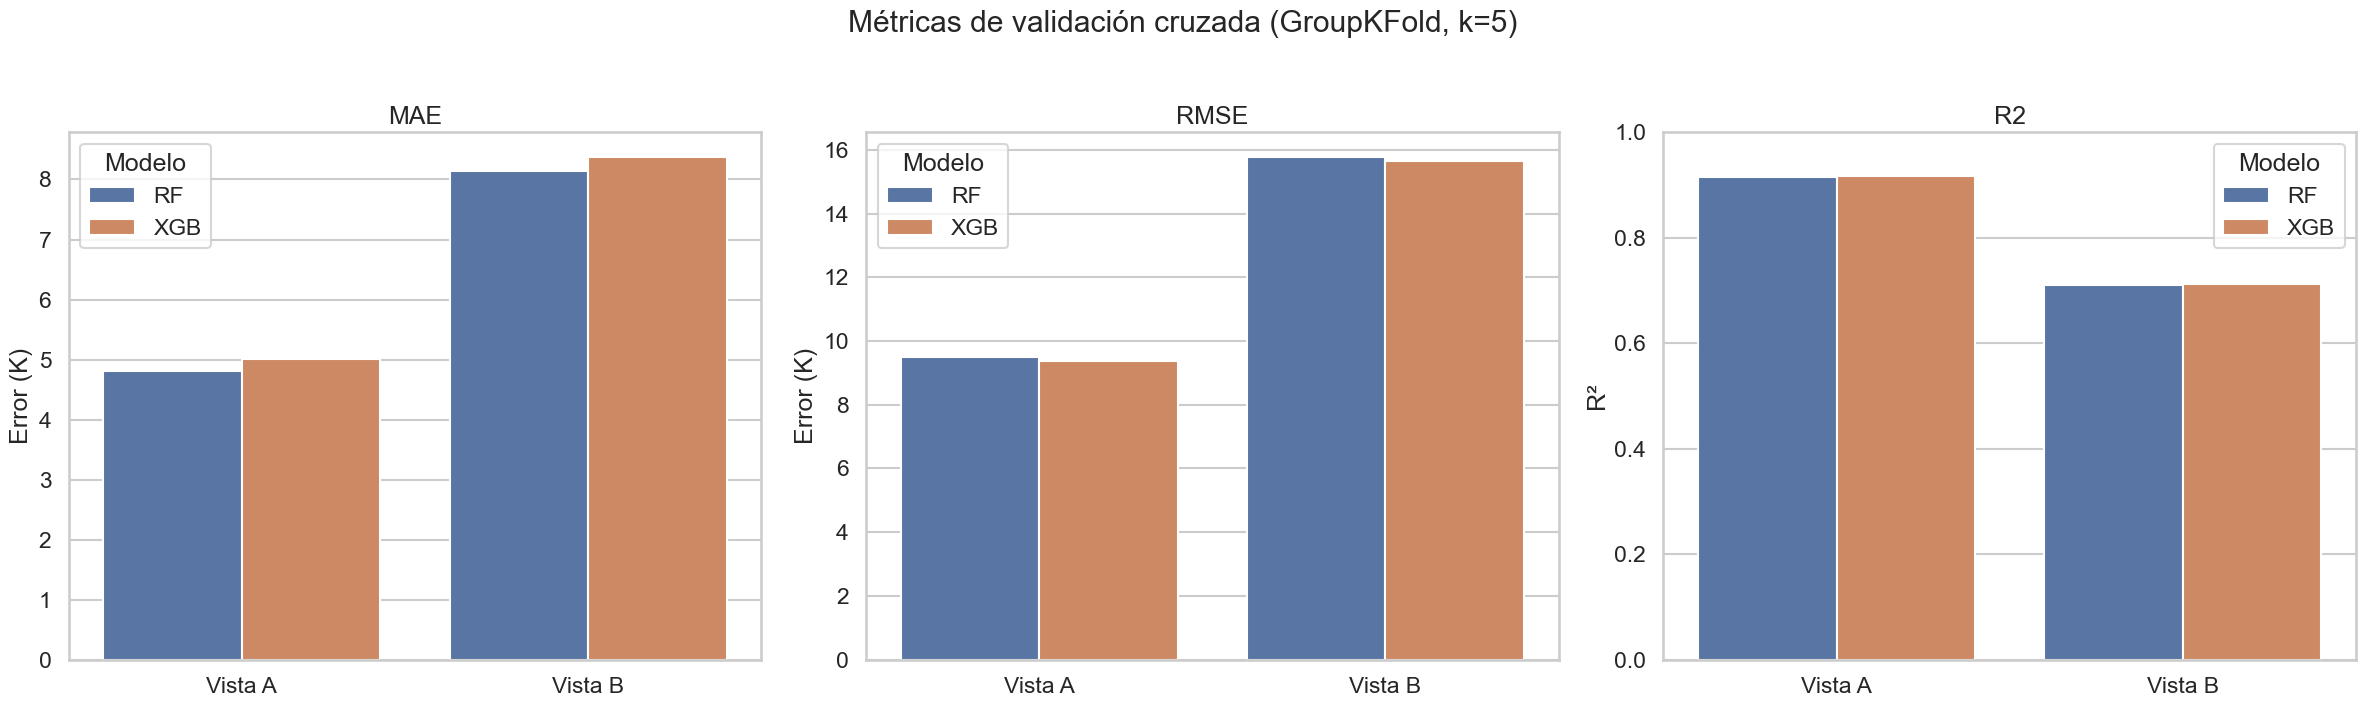

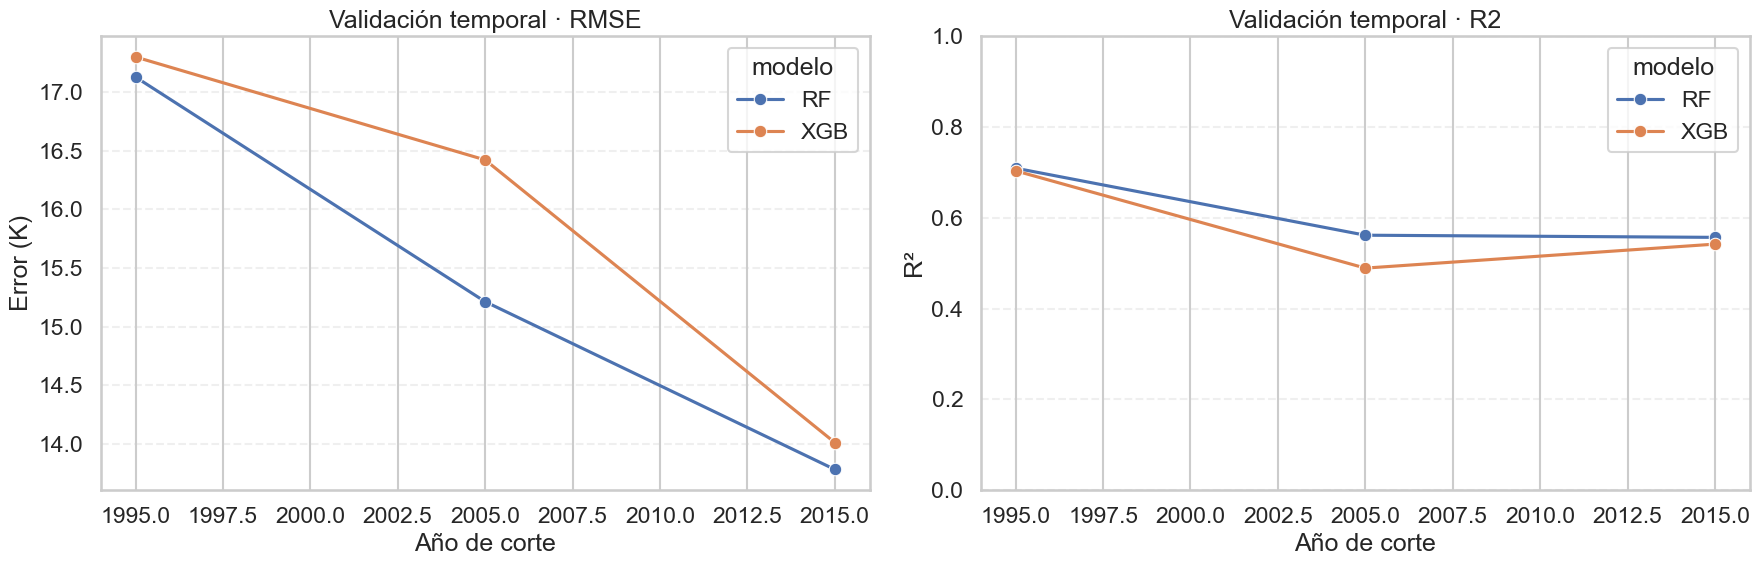

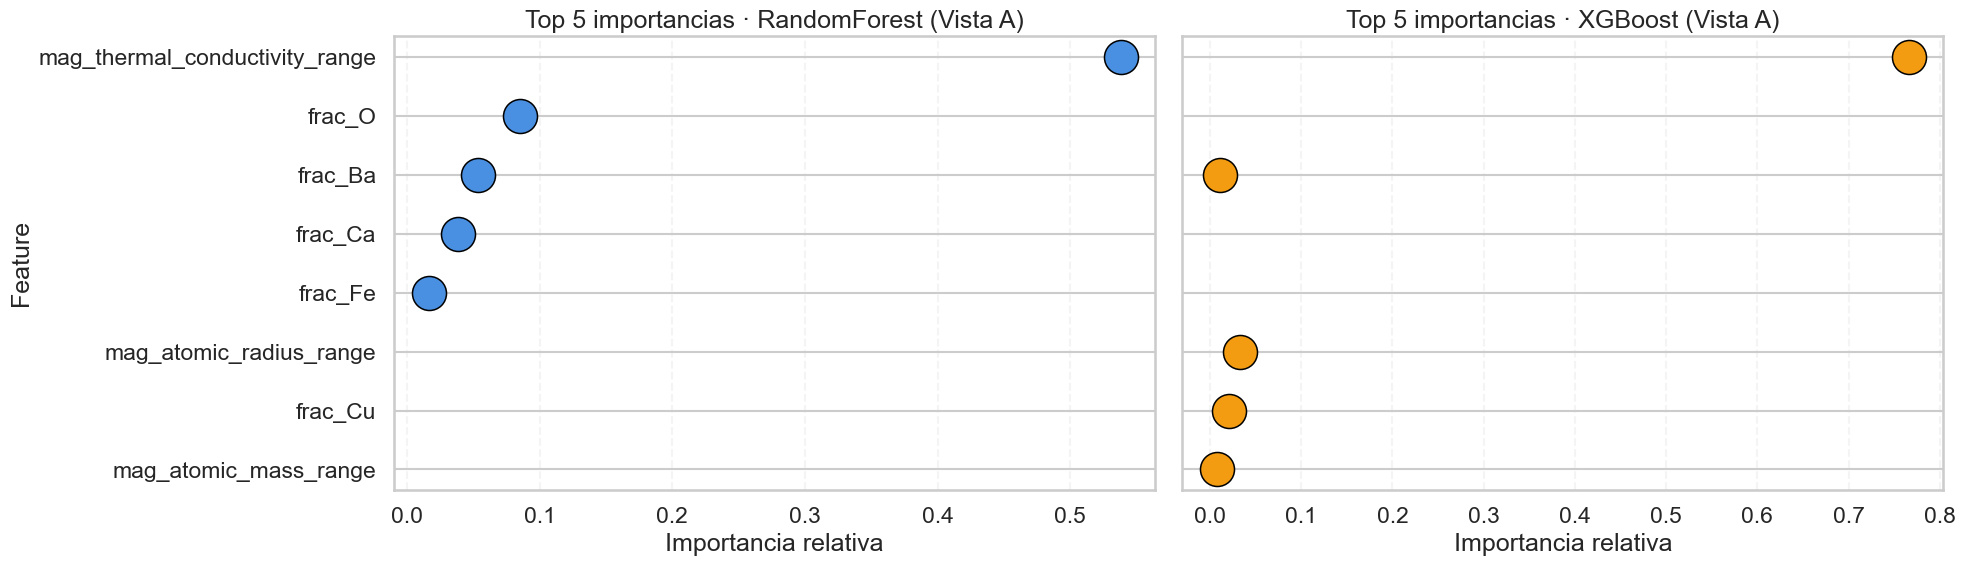

In [28]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

# XGBoost opcional con fallback a HistGradientBoostingRegressor
try:
    from xgboost import XGBRegressor  # type: ignore
    HAVE_XGB_VIS = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingRegressor as XGBRegressor  # type: ignore
    HAVE_XGB_VIS = False

sns.set_theme(style="whitegrid", context="talk")

# ----------------------
# 1) Resumen de métricas CV (Vista A vs B)
# ----------------------

def ensure_view_arrays(df_view: pl.DataFrame):
    feat_cols = [c for c in df_view.columns if c.startswith("frac_") or c.startswith("mag_")]  # noqa: RUF100
    if "comp_entropy" in df_view.columns:
        feat_cols.append("comp_entropy")
    X = df_view.select(feat_cols).to_numpy()
    y = df_view.select("Tc_K").to_numpy().ravel()
    groups = df_view["material_id"].to_list()
    return feat_cols, X, y, groups

feat_A, X_A, y_A, groups_A = ensure_view_arrays(df_A)
feat_B, X_B, y_B, groups_B = ensure_view_arrays(df_B)

views = {
    "Vista A": (feat_A, X_A, y_A, groups_A),
    "Vista B": (feat_B, X_B, y_B, groups_B),
}

metrics_rows = []
for vista, (feats, X, y, groups) in views.items():
    rf_model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
    rf_metrics = eval_cv(X, y, groups, rf_model, n_splits=5, seed=42)
    metrics_rows.append({"vista": vista, "modelo": "RF", **rf_metrics})

    if HAVE_XGB_VIS:
        boost_name = "XGB"
        boost_model = XGBRegressor(
            n_estimators=400, max_depth=8, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.8, tree_method="hist",
            n_jobs=-1, random_state=42,
        )
    else:
        boost_name = "HGB"
        boost_model = XGBRegressor(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)

    boost_metrics = eval_cv(X, y, groups, boost_model, n_splits=5, seed=42)
    metrics_rows.append({"vista": vista, "modelo": boost_name, **boost_metrics})

metrics_df = pd.DataFrame(metrics_rows)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
for metric, ax in zip(["MAE", "RMSE", "R2"], axes):
    sns.barplot(data=metrics_df, x="vista", y=metric, hue="modelo", ax=ax)
    ax.set_title(metric)
    ax.set_xlabel("")
    if metric == "R2":
        ax.set_ylabel("R²")
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel("Error (K)")
    ax.legend(title="Modelo")
fig.suptitle("Métricas de validación cruzada (GroupKFold, k=5)", y=1.02)
plt.tight_layout()
plt.show()

# ----------------------
# 2) Validación temporal (res_rf/res_xg)
# ----------------------
if "res_rf" not in globals() or res_rf.is_empty():
    res_rf = temporal_eval(df_A, model_kind="rf")
if "res_xg" not in globals() or res_xg.is_empty():
    res_xg = temporal_eval(df_A, model_kind="xgb")

temporal_frames = []
if not res_rf.is_empty():
    temporal_frames.append(res_rf.with_columns(pl.lit("RF").alias("modelo")))
if not res_xg.is_empty():
    temporal_frames.append(res_xg.with_columns(pl.lit("XGB" if HAVE_XGB_VIS else "HGB").alias("modelo")))

if temporal_frames:
    temporal_pd = pl.concat(temporal_frames).to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)
    for metric, ax in zip(["RMSE", "R2"], axes):
        sns.lineplot(data=temporal_pd, x="cut_year", y=metric, hue="modelo", marker="o", ax=ax)
        ax.set_title(f"Validación temporal · {metric}")
        ax.set_xlabel("Año de corte")
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        if metric == "RMSE":
            ax.set_ylabel("Error (K)")
        else:
            ax.set_ylabel("R²")
            ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("No hay resultados de validación temporal para graficar.")

# ----------------------
# 3) Importancias de variables (Vista A)
# ----------------------
if "imp_rfA" not in globals():
    path_rf = Path("feat_importances_rfA.csv")
    if path_rf.exists():
        imp_rfA = pl.read_csv(path_rf)
    elif "fit_and_importances" in globals():
        imp_rfA, _, _ = fit_and_importances(RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42), X_A, y_A, feat_A)
    else:
        raise RuntimeError("No se encuentran importancias RF; ejecuta el bloque de entrenamiento previo.")

if "imp_xgbA" not in globals():
    path_xg = Path("feat_importances_xgbA.csv")
    if path_xg.exists():
        imp_xgbA = pl.read_csv(path_xg)
    elif "fit_and_importances" in globals():
        boost_model = XGBRegressor(
            n_estimators=600, max_depth=8, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.8, tree_method="hist",
            n_jobs=-1, random_state=42,
        ) if HAVE_XGB_VIS else XGBRegressor(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)
        imp_xgbA, _, _ = fit_and_importances(boost_model, X_A, y_A, feat_A)
    else:
        raise RuntimeError("No se encuentran importancias XGB/HGB; ejecuta el bloque de entrenamiento previo.")

imp_rf_pd = imp_rfA.to_pandas().sort_values("importance", ascending=False).head(5)
imp_xg_pd = imp_xgbA.to_pandas().sort_values("importance", ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
for data, title, color, ax in [
    (imp_rf_pd, "RandomForest (Vista A)", "#4a90e2", axes[0]),
    (imp_xg_pd, ("XGBoost" if HAVE_XGB_VIS else "HGB") + " (Vista A)", "#f39c12", axes[1]),
]:
    sns.scatterplot(
        data=data,
        x="importance",
        y="feature",
        s=600,
        color=color,
        edgecolor="black",
        linewidth=1.1,
        ax=ax,
    )
    ax.set_title(f"Top 5 importancias · {title}")
    ax.set_xlabel("Importancia relativa")
    ax.set_ylabel("Feature")
    ax.grid(axis="x", linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()


In [29]:
# Label: ¿Tc >= 77 K?
dfA_cls = df_A.with_columns((pl.col("Tc_K") >= 77.0).alias("label_77K"))
feat_cls = [c for c in dfA_cls.columns if c.startswith("frac_") or c.startswith("mag_")] + \
           ([ "comp_entropy" ] if "comp_entropy" in dfA_cls.columns else [])
X = dfA_cls.select(feat_cls).to_numpy()
y = dfA_cls.select("label_77K").to_numpy().ravel().astype(int)
groups = dfA_cls["material_id"].to_list()

from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    clf = XGBClassifier(n_estimators=600, max_depth=8, learning_rate=0.05,
                        subsample=0.9, colsample_bytree=0.8, tree_method="hist",
                        n_jobs=-1, random_state=42, eval_metric="logloss")
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier as HGB
    clf = HGB(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)

gkf = GroupKFold(n_splits=5)
aps, roc, f1m = [], [], []
for tr, te in gkf.split(X, y, groups):
    clf.fit(X[tr], y[tr])
    p  = clf.predict_proba(X[te])[:,1] if hasattr(clf, "predict_proba") else clf.predict(X[te])
    yb = (p >= 0.5).astype(int)
    aps.append(average_precision_score(y[te], p))
    roc.append(roc_auc_score(y[te], p))
    f1m.append(f1_score(y[te], yb))
print({"PR-AUC": float(np.mean(aps)), "ROC-AUC": float(np.mean(roc)), "F1": float(np.mean(f1m))})


{'PR-AUC': 0.9251863994749829, 'ROC-AUC': 0.9868856783146713, 'F1': 0.8510866014443336}


In [30]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

# Usa las matrices generadas en la sección de vistas; si no existen, recalcúlalas.
if "X_A" not in globals() or "y_A" not in globals() or "groups_A" not in globals():
    feat_A, X_A, y_A, groups_A = ensure_view_arrays(df_A)

def quantile_cv(alpha):
    try:
        from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
        model = HGBR(
            loss="quantile",
            quantile=alpha,
            max_depth=6,
            learning_rate=0.05,
            max_iter=1000,
            random_state=42,
        )
        use_imputer = False
    except Exception:
        # Fallback a GradientBoosting con imputación
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.ensemble import GradientBoostingRegressor as GBR

        model = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                (
                    "gbr",
                    GBR(
                        loss="quantile",
                        alpha=alpha,
                        n_estimators=800,
                        learning_rate=0.03,
                        max_depth=3,
                        random_state=42,
                    ),
                ),
            ]
        )
        use_imputer = True

    gkf = GroupKFold(5)
    maes = []
    for tr, te in gkf.split(X_A, y_A, groups_A):
        model.fit(X_A[tr], y_A[tr])
        pred = model.predict(X_A[te])
        maes.append(mean_absolute_error(y_A[te], pred))
    return float(np.mean(maes)), model, use_imputer

mae_p10, model_p10, _ = quantile_cv(0.10)
mae_p50, model_p50, _ = quantile_cv(0.50)
mae_p90, model_p90, _ = quantile_cv(0.90)
print({"MAE_p10": mae_p10, "MAE_p50": mae_p50, "MAE_p90": mae_p90})


{'MAE_p10': 13.86396733811939, 'MAE_p50': 6.166553348016924, 'MAE_p90': 10.99215520154829}


In [31]:
# Matriz co-ocurrencia elementos (simétrica)
ELEMS = [c.replace("frac_","") for c in df_A.columns if c.startswith("frac_")]
A = df_A.select([f"frac_{e}" for e in ELEMS]).to_numpy()
# binariza presencia
B = (A > 0).astype(int)
C = B.T @ B  # co-ocurrencia cruda
# PPMI
row_sums = C.sum(axis=1, keepdims=True)
col_sums = C.sum(axis=0, keepdims=True)
total = C.sum()
P = C / total
Pr = row_sums / total
Pc = col_sums / total
with np.errstate(divide='ignore'):
    PMI = np.log((P + 1e-12) / (Pr @ Pc + 1e-12))
PPMI = np.maximum(PMI, 0.0)

# SVD → embeddings d=16
import numpy.linalg as LA
U, S, Vt = LA.svd(PPMI, full_matrices=False)
d = 16
E_emb = U[:, :d] * S[:d]  # (n_elems, d)
elem_emb = {e: E_emb[i] for i, e in enumerate(ELEMS)}
print("Embedding de 16D para", len(elem_emb), "elementos listo.")


Embedding de 16D para 86 elementos listo.


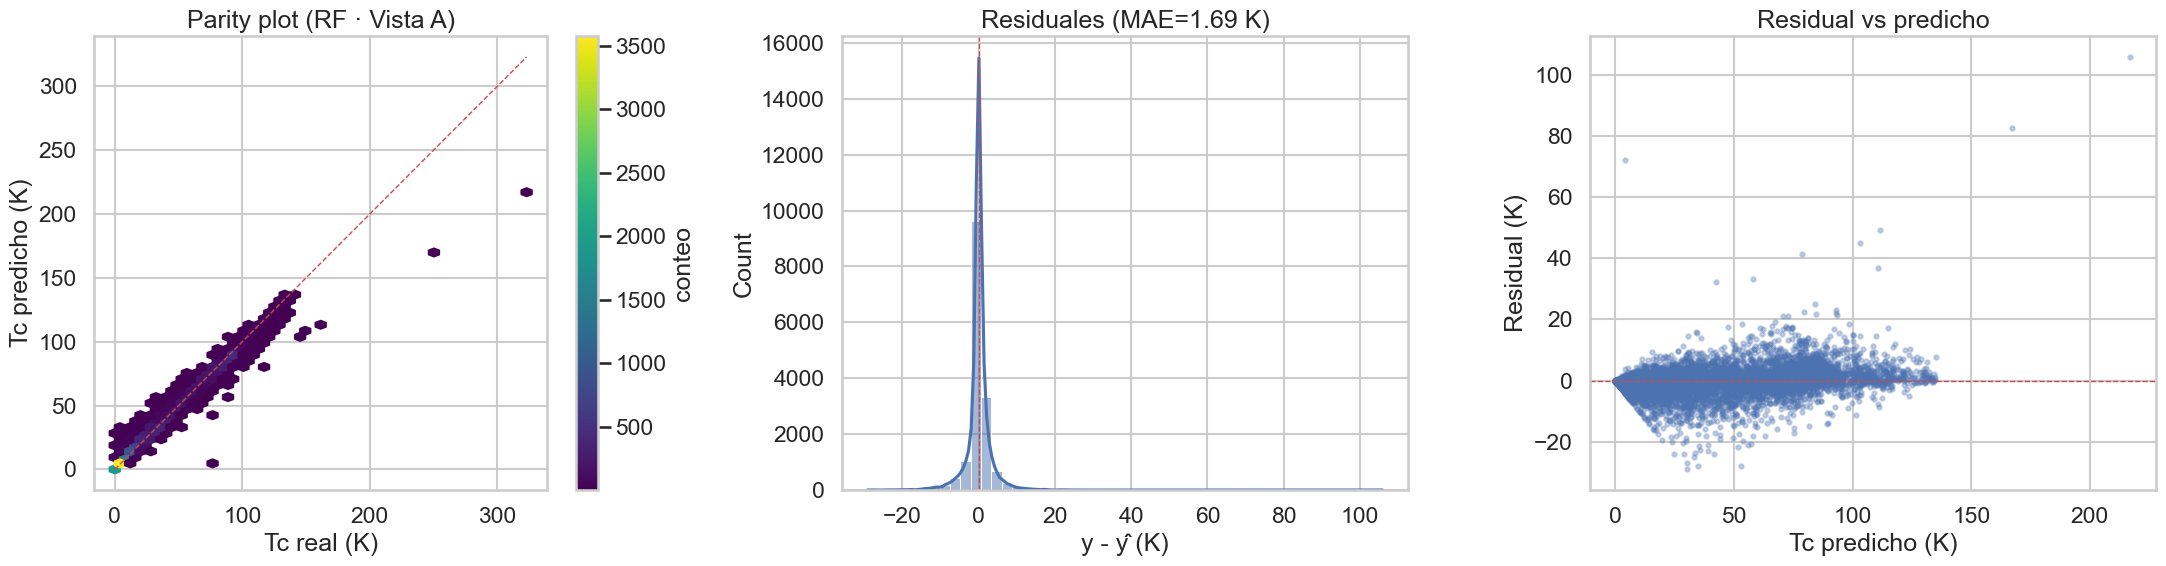

{'Cobertura_empírica_p10-p90': 0.7350352112676056, 'Ancho_mediano_intervalo': 19.16187666273853}


/var/folders/l2/nr7w1d_j7_n68q8tx9xxt2k00000gn/T/ipykernel_55307/1761158022.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cov_by_bin = df_cov.groupby("bin")["covered"].mean().reset_index()


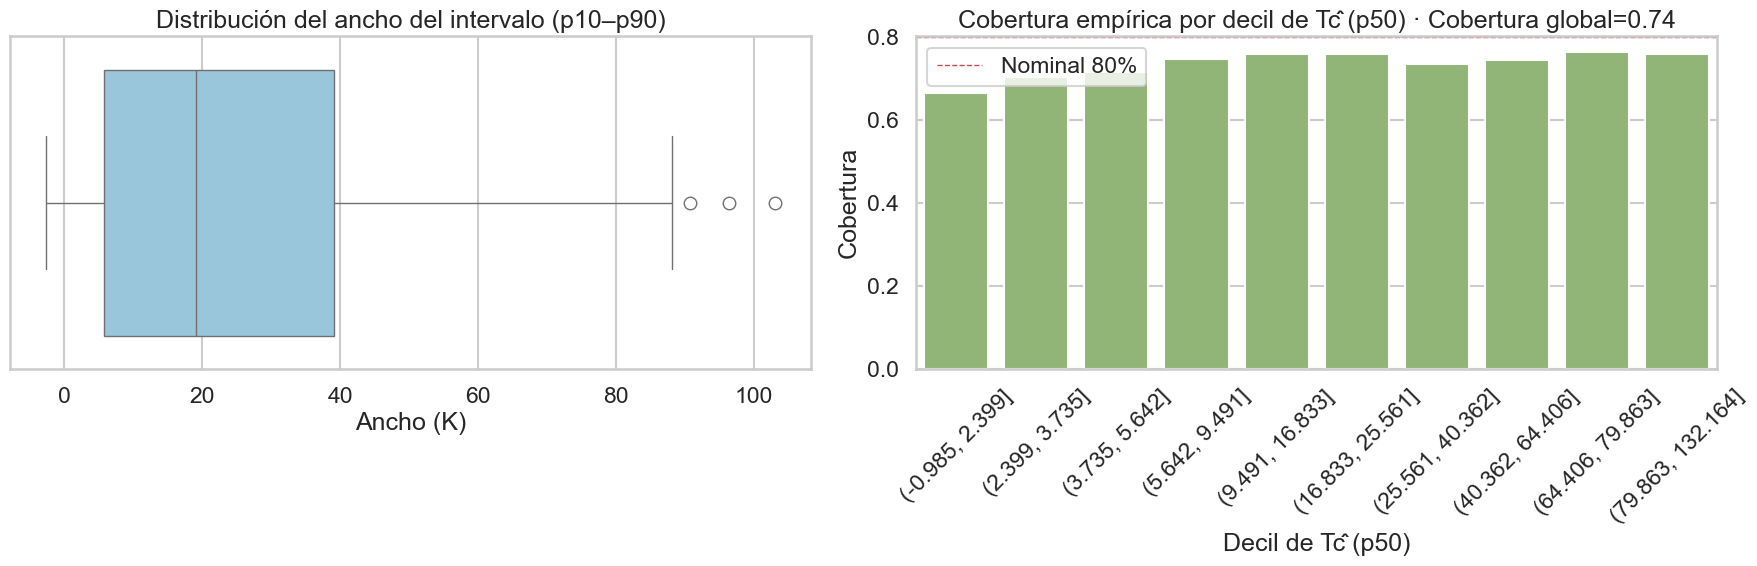

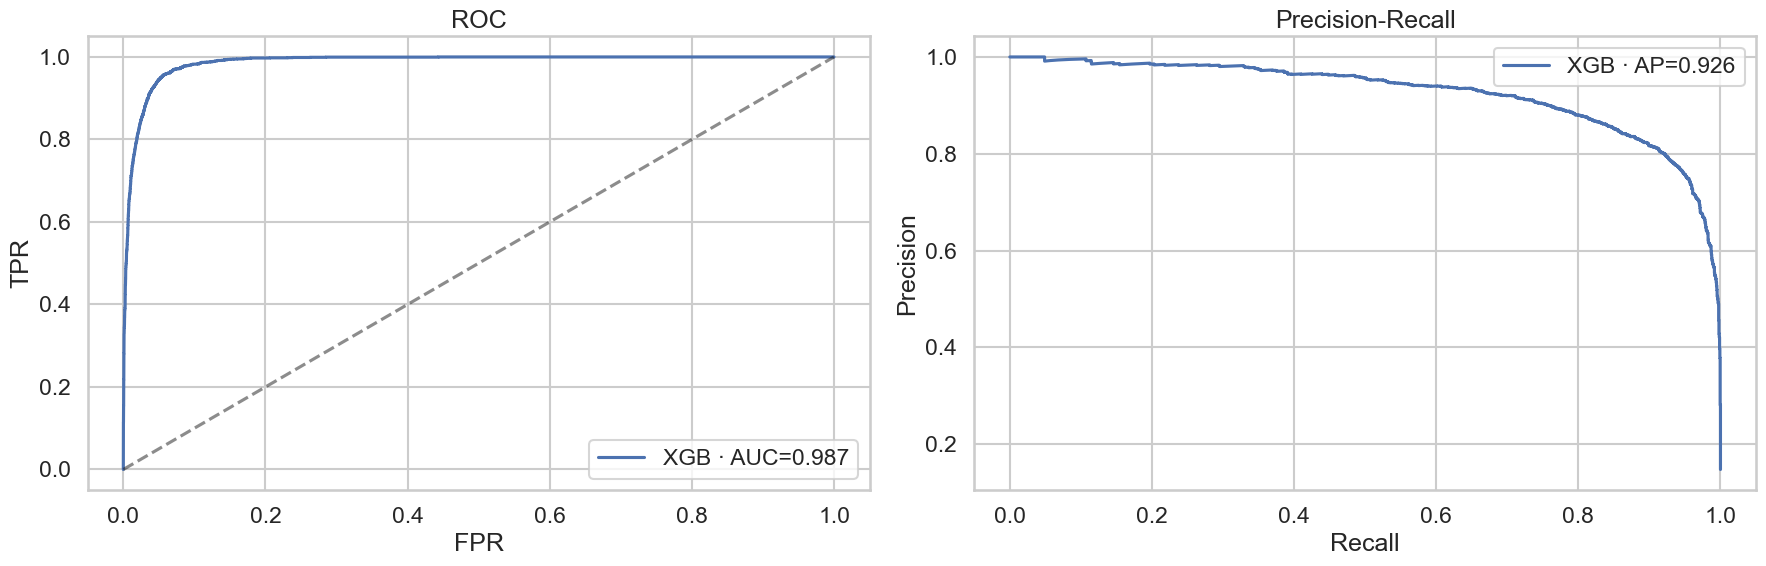

{'threshold_opt_F1': 0.26247555017471313, 'F1': 0.8588612670408982, 'ROC-AUC': 0.9869168872186589, 'PR-AUC': 0.9256295102079505, 'confusion_matrix': [[13058, 496], [208, 2142]]}


In [32]:
# ==========================
# Diagnóstico y calibración del modelo
# ==========================
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    mean_absolute_error, roc_curve, precision_recall_curve, average_precision_score,
    roc_auc_score, f1_score, confusion_matrix
)

sns.set_theme(style="whitegrid", context="talk")

# ---------- A) Parity plot + residuales (RF Vista A) ----------
try:
    rf_model = rfA_fitted
except NameError:
    from sklearn.ensemble import RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42).fit(X_A, y_A)

yhat = rf_model.predict(X_A)
resid = y_A - yhat

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
# Parity (hexbin para densidad)
hb = axes[0].hexbin(y_A, yhat, gridsize=40, cmap="viridis", mincnt=1)
axes[0].plot([y_A.min(), y_A.max()], [y_A.min(), y_A.max()], "r--", lw=1)
axes[0].set_xlabel("Tc real (K)"); axes[0].set_ylabel("Tc predicho (K)")
axes[0].set_title("Parity plot (RF · Vista A)")
cb = fig.colorbar(hb, ax=axes[0]); cb.set_label("conteo")

# Hist residuales
sns.histplot(resid, bins=50, kde=True, ax=axes[1])
axes[1].axvline(0, color="r", linestyle="--", lw=1)
axes[1].set_title(f"Residuales (MAE={mean_absolute_error(y_A, yhat):.2f} K)")
axes[1].set_xlabel("y - ŷ (K)")

# Residual vs predicho
axes[2].scatter(yhat, resid, s=10, alpha=0.3)
axes[2].axhline(0, color="r", linestyle="--", lw=1)
axes[2].set_xlabel("Tc predicho (K)"); axes[2].set_ylabel("Residual (K)")
axes[2].set_title("Residual vs predicho")
plt.tight_layout()
plt.show()

# ---------- B) Calibración de cuantiles (OOF p10/p50/p90) ----------
def make_quantile_model(alpha):
    # Preferir HGBR (rápido y robusto); fallback a GBR con imputación
    try:
        from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
        return HGBR(loss="quantile", quantile=alpha, max_depth=6, learning_rate=0.05, max_iter=600, random_state=42)
    except Exception:
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.ensemble import GradientBoostingRegressor as GBR
        return Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("gbr", GBR(loss="quantile", alpha=alpha, n_estimators=800, learning_rate=0.03, max_depth=3, random_state=42))
        ])

def oof_quantiles(X, y, groups, alphas=(0.1, 0.5, 0.9)):
    gkf = GroupKFold(5)
    preds = {a: np.full_like(y, np.nan, dtype=float) for a in alphas}
    for tr, te in gkf.split(X, y, groups):
        models = {a: make_quantile_model(a) for a in alphas}
        for a, m in models.items():
            m.fit(X[tr], y[tr])
            preds[a][te] = m.predict(X[te])
    return preds

preds_q = oof_quantiles(X_A, y_A, groups_A, alphas=(0.1, 0.5, 0.9))
p10, p50, p90 = preds_q[0.1], preds_q[0.5], preds_q[0.9]
mask = np.isfinite(p10) & np.isfinite(p50) & np.isfinite(p90)

coverage = float(np.mean((y_A[mask] >= p10[mask]) & (y_A[mask] <= p90[mask])))
width = (p90 - p10)[mask]
print({"Cobertura_empírica_p10-p90": coverage, "Ancho_mediano_intervalo": float(np.median(width))})

# Cobertura por deciles de p50
bins = pd.qcut(p50[mask], q=10, duplicates="drop")
df_cov = pd.DataFrame({"bin": bins, "covered": ((y_A[mask] >= p10[mask]) & (y_A[mask] <= p90[mask])).astype(int)})
cov_by_bin = df_cov.groupby("bin")["covered"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x=width, ax=axes[0], color="#8ecae6")
axes[0].set_title("Distribución del ancho del intervalo (p10–p90)")
axes[0].set_xlabel("Ancho (K)")

sns.barplot(data=cov_by_bin, x="bin", y="covered", ax=axes[1], color="#90be6d")
axes[1].axhline(0.8, color="r", linestyle="--", lw=1, label="Nominal 80%")
axes[1].set_title(f"Cobertura empírica por decil de Tĉ (p50) · Cobertura global={coverage:.2f}")
axes[1].set_ylabel("Cobertura"); axes[1].set_xlabel("Decil de Tĉ (p50)")
axes[1].tick_params(axis="x", rotation=45); axes[1].legend()
plt.tight_layout(); plt.show()

# ---------- C) Clasificación: ROC/PR, umbral óptimo y matriz de confusión ----------
# Reusar dataset binario de la celda previa
dfA_cls = df_A.with_columns((pl.col("Tc_K") >= 77.0).alias("label_77K"))
feat_cls = [c for c in dfA_cls.columns if c.startswith("frac_") or c.startswith("mag_")]
if "comp_entropy" in dfA_cls.columns: feat_cls.append("comp_entropy")
Xc = dfA_cls.select(feat_cls).to_numpy()
yc = dfA_cls.select("label_77K").to_numpy().ravel().astype(int)
gc = dfA_cls["material_id"].to_list()

# Clasificador (preferir XGB; fallback a HGB)
try:
    from xgboost import XGBClassifier
    def make_clf():
        return XGBClassifier(
            n_estimators=600, max_depth=8, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.8, tree_method="hist",
            n_jobs=-1, random_state=42, eval_metric="logloss"
        )
    clf_name = "XGB"
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    def make_clf():
        return HistGradientBoostingClassifier(max_depth=8, learning_rate=0.05, max_iter=600, random_state=42)
    clf_name = "HGB"

# OOF probabilidades
gkf = GroupKFold(5)
oof_p = np.full_like(yc, np.nan, dtype=float)
for tr, te in gkf.split(Xc, yc, gc):
    m = make_clf(); m.fit(Xc[tr], yc[tr])
    if hasattr(m, "predict_proba"):
        oof_p[te] = m.predict_proba(Xc[te])[:, 1]
    else:
        # Escala decision_function a [0,1] como aproximación
        s = m.decision_function(Xc[te])
        s = (s - s.min()) / (s.max() - s.min() + 1e-9)
        oof_p[te] = s

# Curvas y umbral óptimo (max F1)
fpr, tpr, thr_roc = roc_curve(yc, oof_p)
prec, rec, thr_pr = precision_recall_curve(yc, oof_p)
ths = np.unique(np.concatenate([thr_roc, thr_pr]))
f1s = []
for t in ths:
    yp = (oof_p >= t).astype(int)
    f1s.append(f1_score(yc, yp))
t_opt = float(ths[int(np.argmax(f1s))])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(fpr, tpr, label=f"{clf_name} · AUC={roc_auc_score(yc, oof_p):.3f}")
axes[0].plot([0,1],[0,1],"k--", alpha=0.5)
axes[0].set_title("ROC"); axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].legend()

axes[1].plot(rec, prec, label=f"{clf_name} · AP={average_precision_score(yc, oof_p):.3f}")
axes[1].set_title("Precision-Recall"); axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].legend()
plt.tight_layout(); plt.show()

yp_opt = (oof_p >= t_opt).astype(int)
cm = confusion_matrix(yc, yp_opt)
print({"threshold_opt_F1": t_opt, "F1": float(f1_score(yc, yp_opt)),
       "ROC-AUC": float(roc_auc_score(yc, oof_p)), "PR-AUC": float(average_precision_score(yc, oof_p)),
       "confusion_matrix":[[int(cm[0,0]), int(cm[0,1])],[int(cm[1,0]), int(cm[1,1])]]})

In [34]:
import json
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np

# === Resumen ejecutivo del flujo y resultados clave ===
# Este script recopila las métricas generadas en el notebook y compone un resumen breve.

# 1) Métricas de CV por vista/modelo
if "metrics_df" not in globals():
    raise RuntimeError("metrics_df no está en memoria; ejecuta la celda de visualización del desempeño (celda 18) antes del resumen.")
metrics_export = metrics_df.copy()

# 2) Validación temporal
if "temporal_frames" in globals() and temporal_frames:
    temporal_export = pd.concat([frame.to_pandas() if isinstance(frame, pl.DataFrame) else frame for frame in temporal_frames], ignore_index=True)
elif "temporal_pd" in globals():
    temporal_export = temporal_pd.copy()
else:
    temporal_export = pd.DataFrame(columns=["cut_year","modelo","RMSE","R2","MAE"]).assign(n_train=np.nan, n_test=np.nan)

# 3) Importancias (top 5)
if "imp_rf_pd" not in globals() or "imp_xg_pd" not in globals():
    raise RuntimeError("Las tablas de importancias no están en memoria; ejecuta la celda 18 primero.")
importances_export = {
    "rf_top5": imp_rf_pd.to_dict(orient="records"),
    "xgb_top5": imp_xg_pd.to_dict(orient="records"),
}

# 4) Métricas de clasificación (si existen)
cls_summary = None
if "oof_p" in globals():
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
    clf_name = "XGB" if HAVE_XGB_VIS else "HGB"
    thr = globals().get("t_opt")
    if thr is not None:
        yp = (oof_p >= thr).astype(int)
        cls_summary = {
            "modelo": clf_name,
            "ROC_AUC": float(roc_auc_score(yc, oof_p)),
            "PR_AUC": float(average_precision_score(yc, oof_p)),
            "F1_opt": float(f1_score(yc, yp)),
            "threshold_opt": float(thr),
        }

# 5) Intervalos cuantílicos (si existen)
quantile_summary = None
if "mae_p10" in globals():
    quantile_summary = {
        "MAE_p10": float(mae_p10),
        "MAE_p50": float(mae_p50),
        "MAE_p90": float(mae_p90),
    }

# Construcción del texto de referencia
lines = [
    "Resumen del flujo Superconductors:\n",
    "1. Limpieza y normalización de Tc + control de calidad (banderas y deduplicación).",
    "2. Extracción de features fisicoquímicos (bag-of-elements + magpie) y creación de dos vistas: Vista A = una fila por material con Tc mediana e IQR; Vista B = todas las mediciones originales por publicación.",
    "3. Entrenamiento y validación cruzada (GroupKFold) con RandomForest y XGBoost/HistGB en ambas vistas.",
    "4. Validación temporal y análisis de importancias para interpretar drivers de Tc.",
    "5. Evaluación adicional: clasificación para Tc>=77K y cuantiles predictivos cuando aplica.",
    "\nResultados clave:\n",
    f"• CV Vista A RF: MAE {metrics_export.query('vista==\"Vista A\" & modelo==\"RF\"')['MAE'].iloc[0]:.2f} K, RMSE {metrics_export.query('vista==\"Vista A\" & modelo==\"RF\"')['RMSE'].iloc[0]:.2f} K, R² {metrics_export.query('vista==\"Vista A\" & modelo==\"RF\"')['R2'].iloc[0]:.3f}.",
    f"• CV Vista A {metrics_export.query('vista==\"Vista A\" & modelo!=\"RF\"')['modelo'].iloc[0]}: MAE {metrics_export.query('vista==\"Vista A\" & modelo!=\"RF\"')['MAE'].iloc[0]:.2f} K, RMSE {metrics_export.query('vista==\"Vista A\" & modelo!=\"RF\"')['RMSE'].iloc[0]:.2f} K, R² {metrics_export.query('vista==\"Vista A\" & modelo!=\"RF\"')['R2'].iloc[0]:.3f}.",
    f"• CV Vista B RF: MAE {metrics_export.query('vista==\"Vista B\" & modelo==\"RF\"')['MAE'].iloc[0]:.2f} K, RMSE {metrics_export.query('vista==\"Vista B\" & modelo==\"RF\"')['RMSE'].iloc[0]:.2f} K, R² {metrics_export.query('vista==\"Vista B\" & modelo==\"RF\"')['R2'].iloc[0]:.3f}.",
    f"• CV Vista B {metrics_export.query('vista==\"Vista B\" & modelo!=\"RF\"')['modelo'].iloc[0]}: MAE {metrics_export.query('vista==\"Vista B\" & modelo!=\"RF\"')['MAE'].iloc[0]:.2f} K, RMSE {metrics_export.query('vista==\"Vista B\" & modelo!=\"RF\"')['RMSE'].iloc[0]:.2f} K, R² {metrics_export.query('vista==\"Vista B\" & modelo!=\"RF\"')['R2'].iloc[0]:.3f}.",
    "• Top 5 features RF: " + ", ".join(f"{row['feature']} ({row['importance']:.2f})" for row in importances_export['rf_top5']),
    "• Top 5 features Boosting: " + ", ".join(f"{row['feature']} ({row['importance']:.2f})" for row in importances_export['xgb_top5']),
 ]
if cls_summary:
    lines.append(f"• Clasificación {cls_summary['modelo']}: ROC-AUC {cls_summary['ROC_AUC']:.3f}, PR-AUC {cls_summary['PR_AUC']:.3f}, F1 {cls_summary['F1_opt']:.3f} (umbral {cls_summary['threshold_opt']:.2f}).")
if quantile_summary:
    lines.append(f"• MAE cuantiles: p10={quantile_summary['MAE_p10']:.2f} K, p50={quantile_summary['MAE_p50']:.2f} K, p90={quantile_summary['MAE_p90']:.2f} K.")
lines.append("\nLos datos auxiliares quedan disponibles en JSON para reportes adicionales.")

summary_text = "\n".join(lines)
print(summary_text)

summary_payload = {
    "metrics_cv": metrics_export.to_dict(orient="records"),
    "temporal_validation": temporal_export.to_dict(orient="records"),
    "importances": importances_export,
    "classification": cls_summary,
    "quantile": quantile_summary,
    "summary_text": summary_text,
}

out_path = Path("model_summary.json")
out_path.write_text(json.dumps(summary_payload, indent=2, ensure_ascii=False))
print(f"\nResumen guardado en {out_path.resolve()}")

Resumen del flujo Superconductors:

1. Limpieza y normalización de Tc + control de calidad (banderas y deduplicación).
2. Extracción de features fisicoquímicos (bag-of-elements + magpie) y creación de dos vistas: Vista A = una fila por material con Tc mediana e IQR; Vista B = todas las mediciones originales por publicación.
3. Entrenamiento y validación cruzada (GroupKFold) con RandomForest y XGBoost/HistGB en ambas vistas.
4. Validación temporal y análisis de importancias para interpretar drivers de Tc.
5. Evaluación adicional: clasificación para Tc>=77K y cuantiles predictivos cuando aplica.

Resultados clave:

• CV Vista A RF: MAE 4.82 K, RMSE 9.49 K, R² 0.914.
• CV Vista A XGB: MAE 5.01 K, RMSE 9.36 K, R² 0.917.
• CV Vista B RF: MAE 8.15 K, RMSE 15.76 K, R² 0.711.
• CV Vista B XGB: MAE 8.37 K, RMSE 15.64 K, R² 0.713.
• Top 5 features RF: mag_thermal_conductivity_range (0.54), frac_O (0.09), frac_Ba (0.05), frac_Ca (0.04), frac_Fe (0.02)
• Top 5 features Boosting: mag_thermal_conduc